In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
dataset = MNIST(root='dataset/', train=True, download=True, transform=transform)
trainloader = DataLoader(dataset, batch_size=100, shuffle=True)

device = 'cuda'

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))
    
    error.backward()
    optimizer.step()
    
    return error

In [ ]:
num_epochs = 1000
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error.detach().cpu().numpy()/i)
    d_losses.append(d_error.detach().cpu().numpy()/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))
    
print('Training Finished')
torch.save(generator.state_dict(), 'mnist_generator.pth')

Epoch 0: g_loss: 1.03545964 d_loss: 1.09109461
Epoch 1: g_loss: 1.52802861 d_loss: 1.10761511
Epoch 2: g_loss: 2.16373825 d_loss: 1.02805197
Epoch 3: g_loss: 1.16032457 d_loss: 1.50833976
Epoch 4: g_loss: 1.95078278 d_loss: 1.11240780
Epoch 5: g_loss: 2.19145274 d_loss: 1.05775595
Epoch 6: g_loss: 1.43285322 d_loss: 1.18198276
Epoch 7: g_loss: 2.24937391 d_loss: 1.19987082
Epoch 8: g_loss: 1.82166791 d_loss: 1.04739702
Epoch 9: g_loss: 2.01117468 d_loss: 1.20134830
Epoch 10: g_loss: 2.48126864 d_loss: 0.81265002
Epoch 11: g_loss: 2.40657616 d_loss: 0.85447699
Epoch 12: g_loss: 1.99818945 d_loss: 1.18020821
Epoch 13: g_loss: 2.55313492 d_loss: 0.74281883
Epoch 14: g_loss: 1.50116014 d_loss: 0.99207985
Epoch 15: g_loss: 1.56001651 d_loss: 1.10917568
Epoch 16: g_loss: 1.82516360 d_loss: 0.89484113
Epoch 17: g_loss: 2.19308519 d_loss: 0.92907411
Epoch 18: g_loss: 1.90482140 d_loss: 0.86662936
Epoch 19: g_loss: 2.35128975 d_loss: 0.81426167
Epoch 20: g_loss: 2.60767007 d_loss: 0.52266842
Ep

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

In [ ]:
import math
g_sum = 0
d_sum = 0
for ele in g_losses:
  g_sum += ele
g_res = g_sum / len(g_losses)

for ele in d_losses:
  d_sum += ele
d_res = d_sum / len(d_losses)  

# printing result 
print("Average generator loss: " + str(g_res))
print("Average discriminator loss: " + str(d_res))  

Average generator loss: 3.0853523653168087
Average discriminator loss: 0.5007286069417732


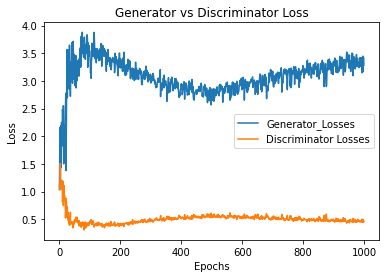

In [ ]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator vs Discriminator Loss')
plt.legend()
plt.savefig('loss.png')